In [2]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.eval_utils import join_real_generated

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right
from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

**Util function**

In [3]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'dentategyrus' / 'dentategyrus_test.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters', 'Age'],
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 128, 
                    'multimodal': False, 
                    'is_binarized': False,
                    'theta_covariate': 'cluster', 
                    'size_factor_covariate': 'clusters',
                 }

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"]
                      )

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
n_cat = len(dataset.id2cov["clusters"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [4]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False, 
    "multimodal": False,
    "is_binarized": False}


state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_train_autoencoder_dentategyrus_whole_genome/feab789d-5b04-45c4-b26a-cbaf0d44755a/checkpoints/epoch_59.ckpt"

In [5]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["theta_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initialize FM model

In [6]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [7]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/MULTILAB_DENTATE/d5275740-92b4-45e8-8760-9ed3419db5f1/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [8]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["clusters"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 1.9384,  1.1092,  1.6160,  ...,  0.1017, -0.9452, -1.1770],
        [-0.4271, -1.6690, -0.0806,  ..., -0.9951, -0.5990,  0.1240],
        [ 0.2407, -0.6385, -0.8284,  ..., -0.1084,  0.5316, -0.2964],
        ...,
        [-0.9051, -0.2766, -0.1216,  ...,  0.5990, -0.7070,  1.1130],
        [-0.2930,  0.9634, -0.8552,  ..., -0.1644,  0.4232,  0.5827],
        [-0.9678, -0.8489,  2.0743,  ...,  0.9663, -2.4510, -2.9606]],
       device='cuda:0', requires_grad=True)


Initializations

In [9]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'clusters': 2, 'Age': 2},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=17002, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
         

**Check the data**

In [10]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
adata_original.X = adata_original.layers["X_counts"].A.copy()
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [11]:
adata_original.X

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


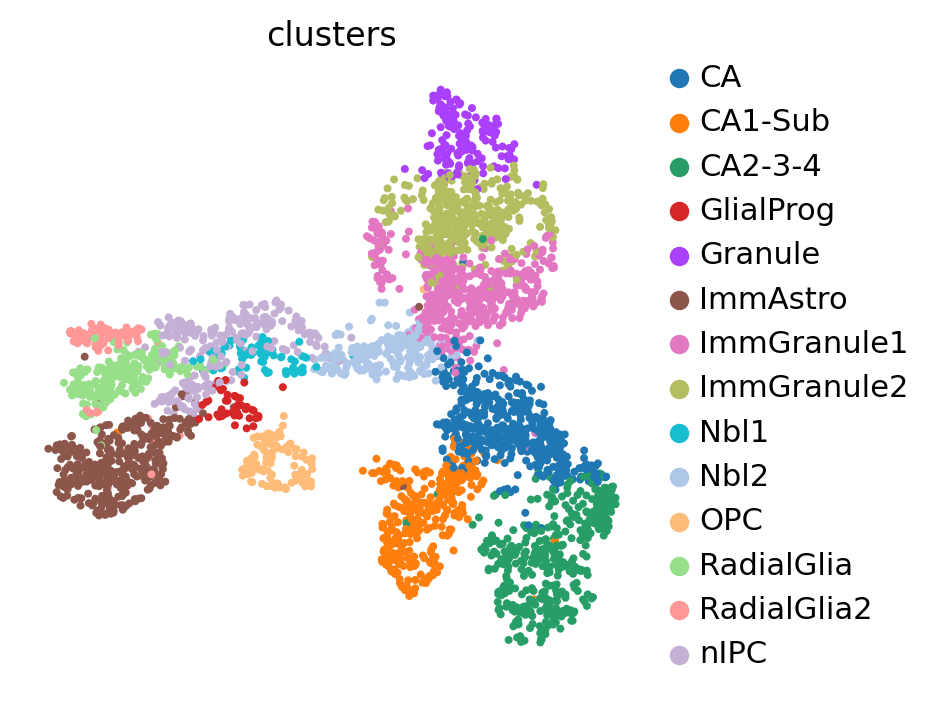

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


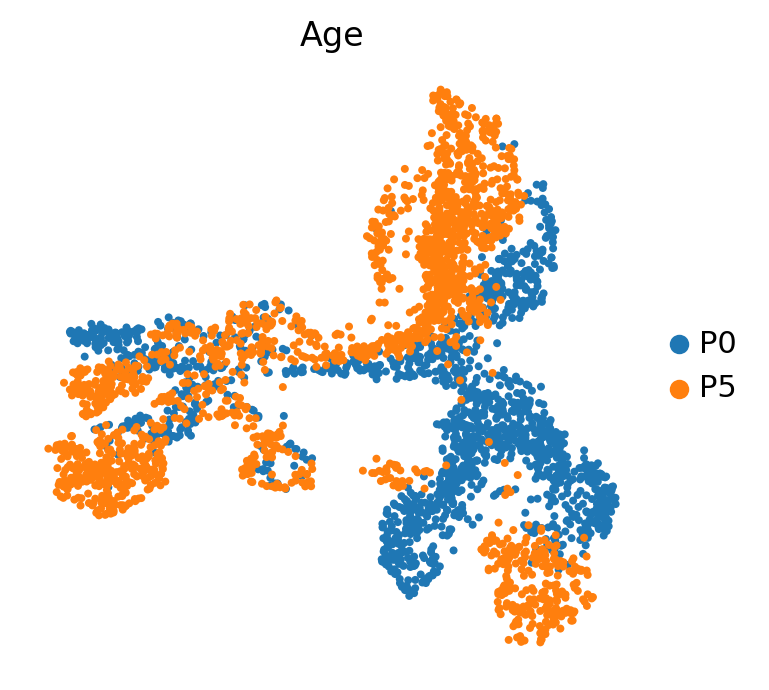

In [12]:
sc.pl.umap(adata_original, color="clusters")
sc.pl.umap(adata_original, color="Age")

# COMBINATION OF CONDITIONS 

In [13]:
generative_model.guidance_weights

{'clusters': 2, 'Age': 2}

In [14]:
dataset.id2cov["clusters"]

{'CA': 0,
 'CA1-Sub': 1,
 'CA2-3-4': 2,
 'GlialProg': 3,
 'Granule': 4,
 'ImmAstro': 5,
 'ImmGranule1': 6,
 'ImmGranule2': 7,
 'Nbl1': 8,
 'Nbl2': 9,
 'OPC': 10,
 'RadialGlia': 11,
 'RadialGlia2': 12,
 'nIPC': 13}

In [15]:
dataset.id2cov["Age"]

{'P0': 0, 'P5': 1}

In [16]:
# Pick condition 
covariates_cell_types = 'CA2-3-4'
covariates_age = 'P0'

condition_id_clus = dataset.id2cov["clusters"][covariates_cell_types]
condition_id_age = dataset.id2cov["Age"][covariates_age]

adata_cond = adata_original[np.logical_and(adata_original.obs.clusters==covariates_cell_types, 
                                           adata_original.obs.Age==covariates_age)]
n_to_generate = adata_cond.shape[0]

classes = {"clusters": condition_id_clus*torch.ones(n_to_generate).long(), 
           "Age": condition_id_age*torch.ones(n_to_generate).long()}

classes_str = {"clusters": [covariates_cell_types for n in range(n_to_generate)], 
           "Age": [covariates_age for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [17]:
X_generated = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="clusters", 
                                        size_factor_covariate="clusters",
                                        conditioning_covariates=["clusters", "Age"],
                                        covariate_indices=classes, 
                                        log_size_factor=None)

X_generated = X_generated.to("cpu")

adata_generated = sc.AnnData(X=X_generated.numpy())

In [18]:
adata_merged = join_real_generated(adata_original, adata_generated, True, classes_str, ["clusters", "Age"])

In [19]:
X_generated.sum(1).max()

tensor(33308.)

In [20]:
X.sum(1).max()

tensor(33111.)

In [21]:
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

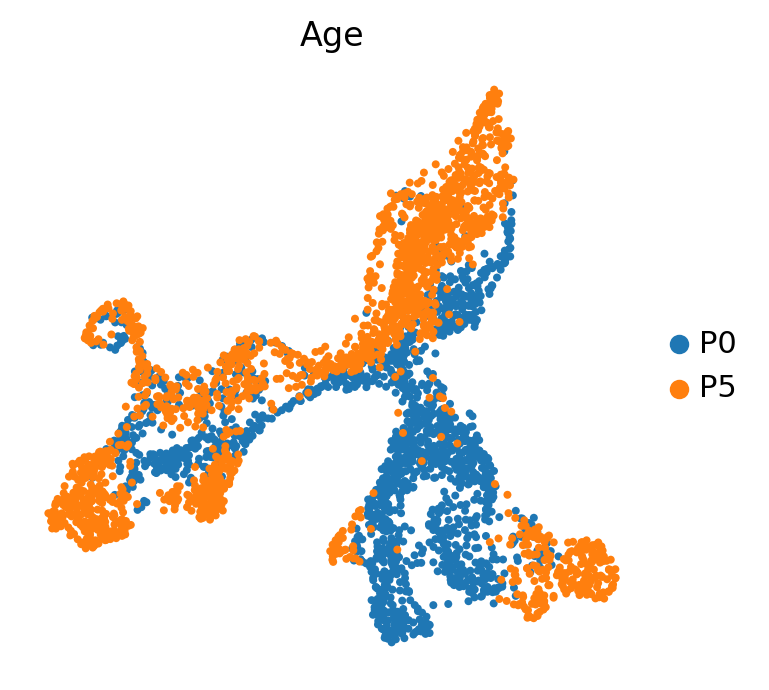

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

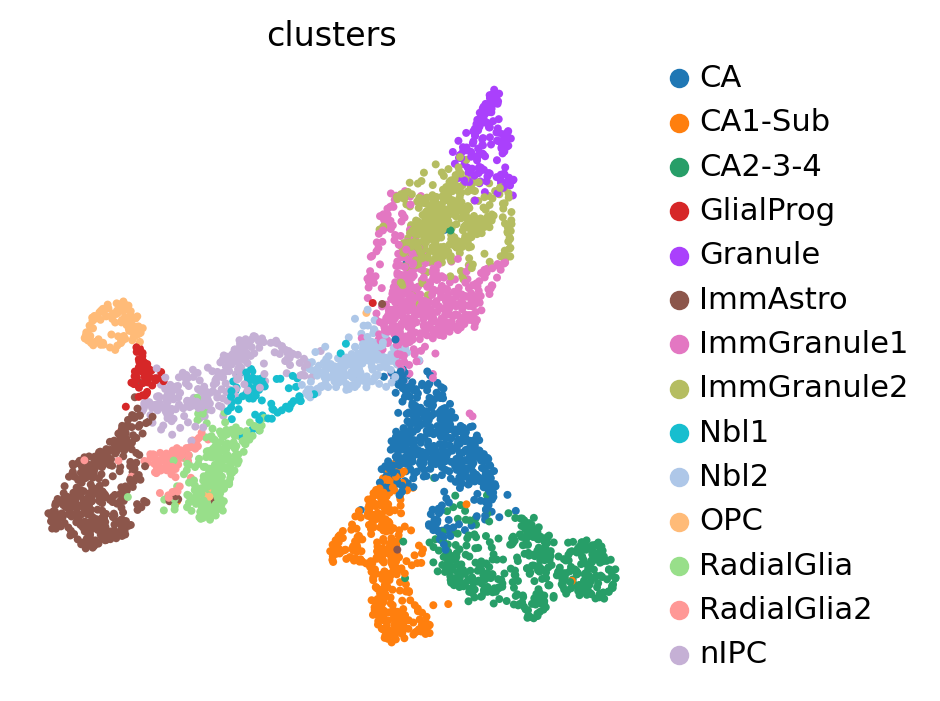

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


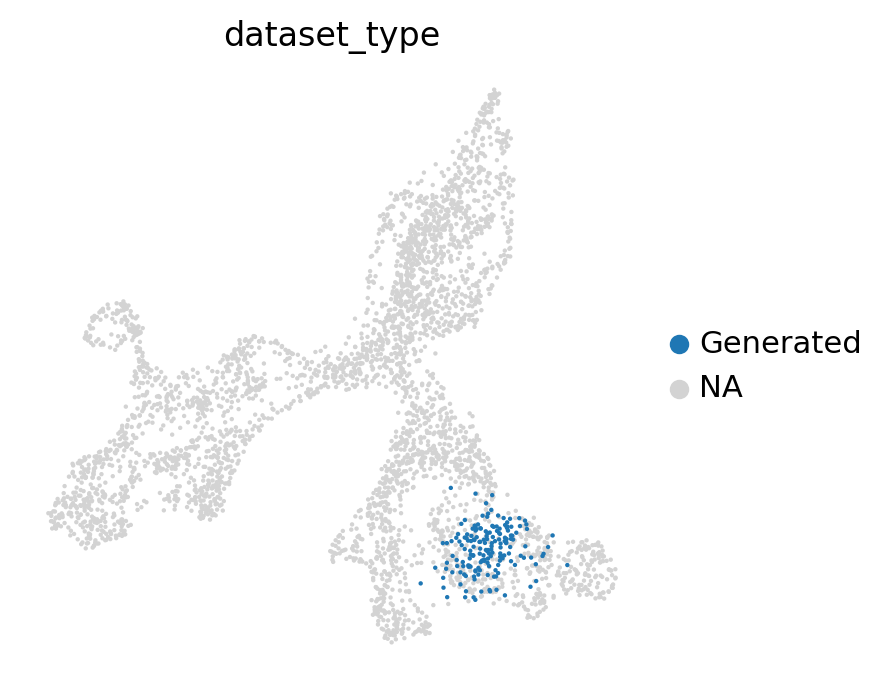

In [22]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="Age")
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="clusters")
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated", s=10)

## SINGLE CONDITION - clusters

In [23]:
# Pick condition 
covariates_cell_types = 'CA2-3-4'

condition_id_clus = dataset.id2cov["clusters"][covariates_cell_types]

adata_cond = adata_original[adata_original.obs.clusters==covariates_cell_types]

n_to_generate = adata_cond.shape[0]

classes = {"clusters": condition_id_clus*torch.ones(n_to_generate).long(), 
           "Age": condition_id_age*torch.ones(n_to_generate).long()}

classes_str = {"clusters": [covariates_cell_types for n in range(n_to_generate)], 
           "Age": [covariates_age for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [24]:
X_generated_clusters = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="clusters", 
                                        size_factor_covariate="clusters",
                                        conditioning_covariates=["clusters"],
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors)

adata_generated_cluster = sc.AnnData(X=X_generated_clusters.cpu().numpy())

In [25]:
adata_merged_cluster = join_real_generated(adata_original, adata_generated_cluster, True, classes_str, ["clusters", "Age"])

In [26]:
sc.pp.neighbors(adata_merged_cluster)
sc.tl.umap(adata_merged_cluster)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

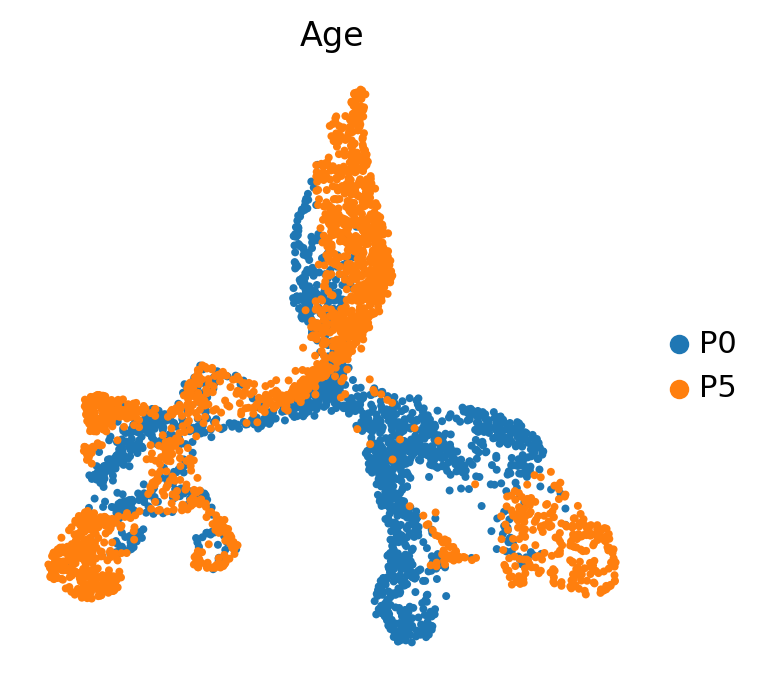

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

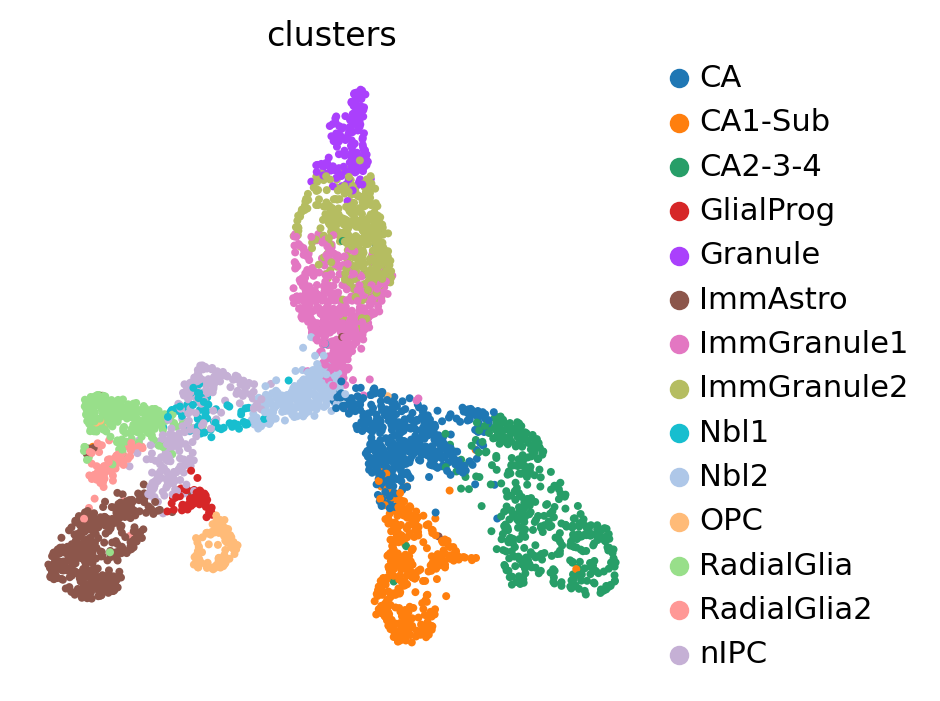

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


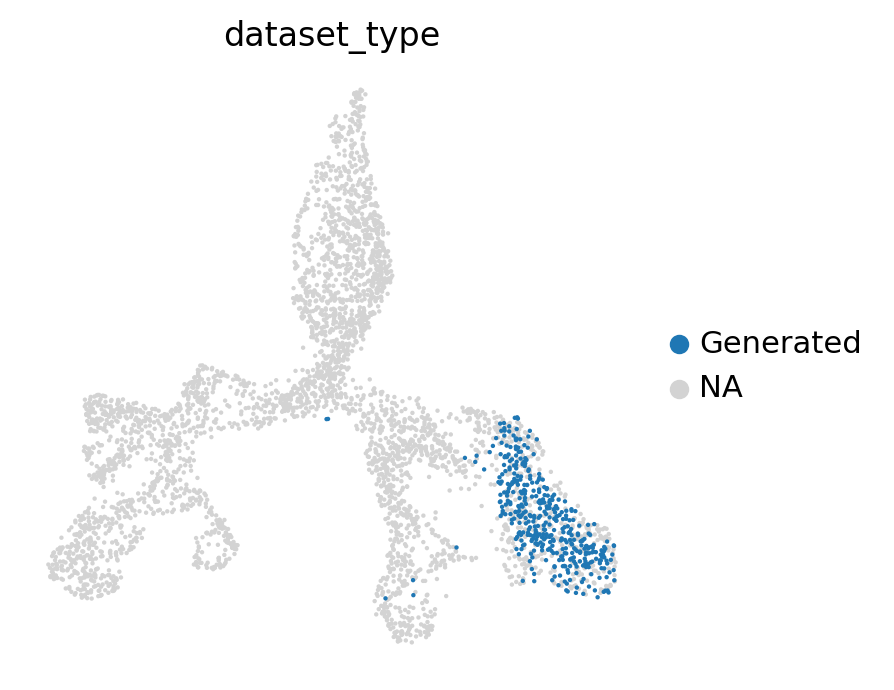

In [27]:
sc.pl.umap(adata_merged_cluster[adata_merged_cluster.obs.dataset_type=="Real"], color="Age")
sc.pl.umap(adata_merged_cluster[adata_merged_cluster.obs.dataset_type=="Real"], color="clusters")
sc.pl.umap(adata_merged_cluster, color="dataset_type", groups="Generated", s=10)

## SINGLE CONDITION - Age

In [28]:
# Pick condition 
covariates_age = 'P0'

condition_id_age = dataset.id2cov["Age"][covariates_age]

adata_cond = adata_original[adata_original.obs.Age==covariates_age]
n_to_generate = adata_cond.shape[0]

classes = {"clusters": condition_id_clus*torch.ones(n_to_generate).long(), 
           "Age": condition_id_age*torch.ones(n_to_generate).long()}

classes_str = {"clusters": [covariates_cell_types for n in range(n_to_generate)], 
           "Age": [covariates_age for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [29]:
X_generated_age = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=2, 
                                        theta_covariate="clusters", 
                                        size_factor_covariate="clusters",
                                        conditioning_covariates=["Age"],
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors)

adata_generated_age = sc.AnnData(X=X_generated_age.cpu().numpy())

In [30]:
adata_merged_age = join_real_generated(adata_original, adata_generated_age, True, classes_str, ["clusters", "Age"])

In [31]:
sc.pp.neighbors(adata_merged_age)
sc.tl.umap(adata_merged_age)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

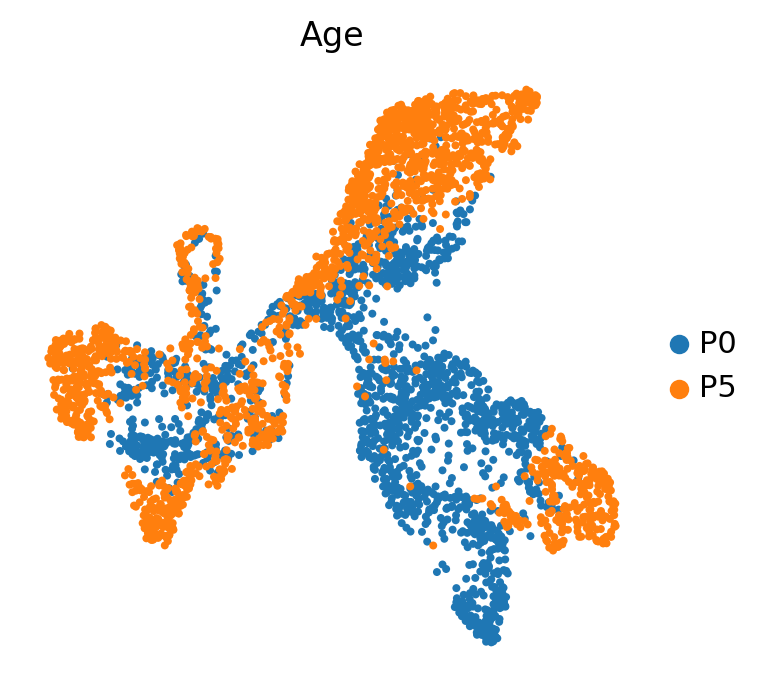

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

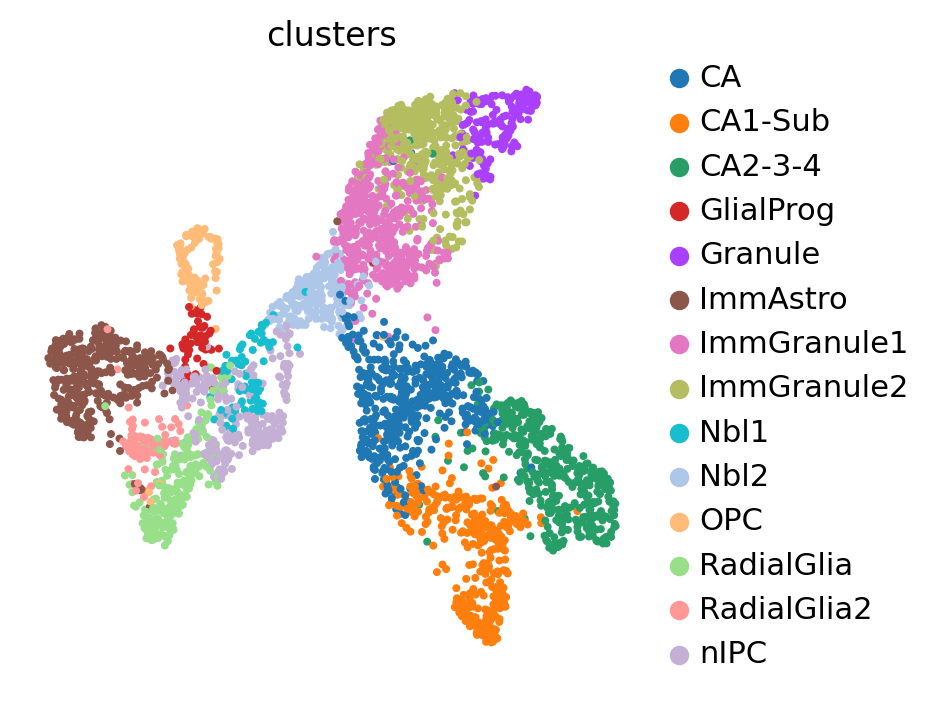

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


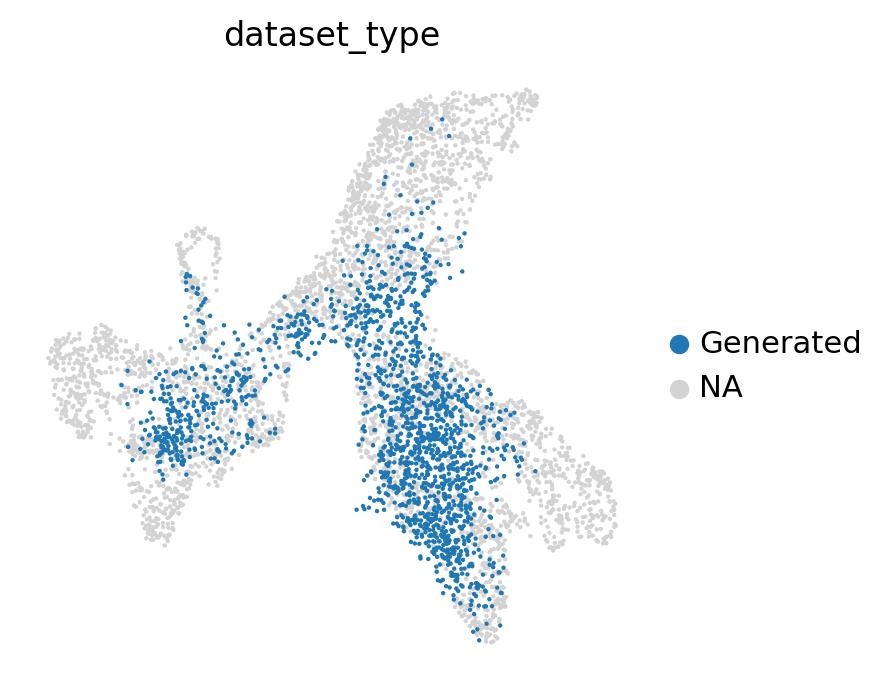

In [32]:
sc.pl.umap(adata_merged_age[adata_merged_age.obs.dataset_type=="Real"], color="Age")
sc.pl.umap(adata_merged_age[adata_merged_age.obs.dataset_type=="Real"], color="clusters")
sc.pl.umap(adata_merged_age, color="dataset_type", groups="Generated", s=10)

## UNCONDITIONAL

In [33]:
num_indices = 3000
index_range = len(X)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

classes_cluster_str =  list(adata_indices.obs.clusters)
classes_cluster = torch.tensor([dataset.id2cov["clusters"][c] for  c in classes_cluster_str]).cuda()

classes_age_str =  list(adata_indices.obs.Age)
classes_age = torch.tensor([dataset.id2cov["Age"][c] for  c in classes_age_str]).cuda()

classes_str = {"clusters": classes_cluster_str,
                  "Age": classes_age_str}


log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()

In [34]:
X_generated_uncond = generative_model.sample(batch_size=num_indices,
                                            n_sample_steps=2, 
                                            theta_covariate="clusters", 
                                            size_factor_covariate="clusters",
                                            conditioning_covariates=["clusters"],
                                            covariate_indices=None, 
                                            log_size_factor=log_size_factors, 
                                            unconditional=True)

X_generated_uncond = X_generated_uncond.to("cpu")

adata_generated_uncond = sc.AnnData(X=X_generated_uncond.cpu().numpy())

In [35]:
adata_merged_uncond = join_real_generated(adata_original, adata_generated_uncond, True, classes_str, ["clusters", "Age"])

In [36]:
sc.pp.neighbors(adata_merged_uncond)
sc.tl.umap(adata_merged_uncond)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

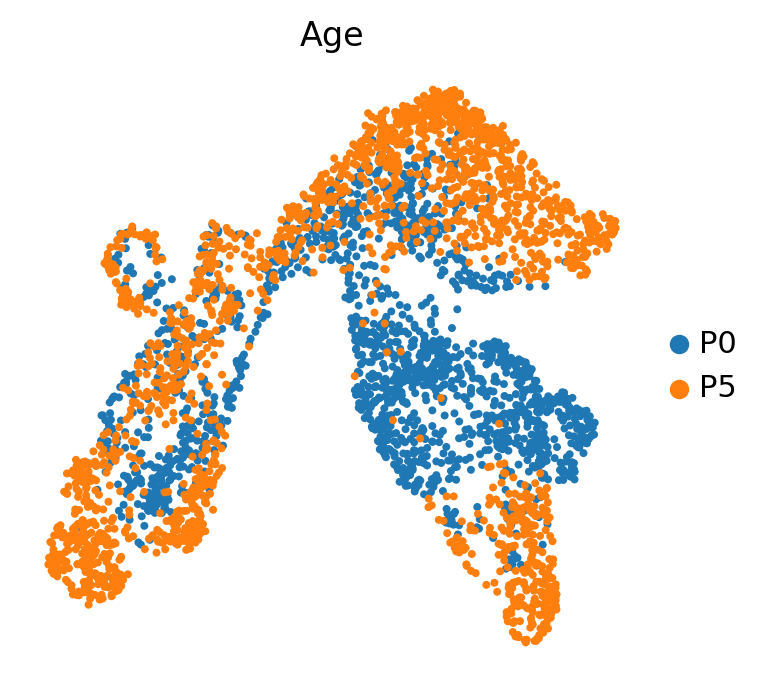

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

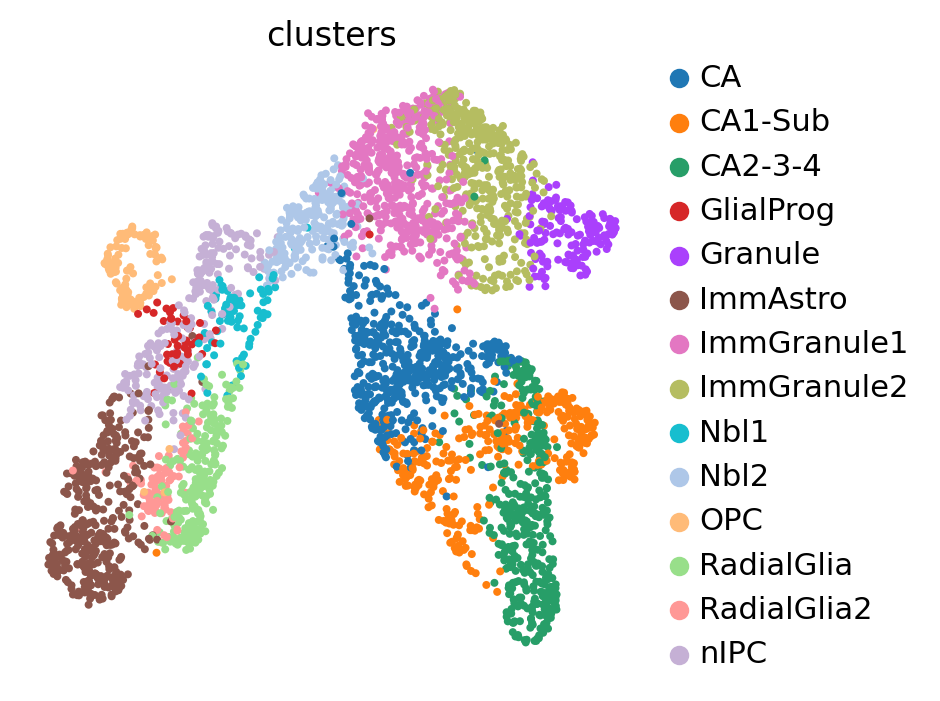

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


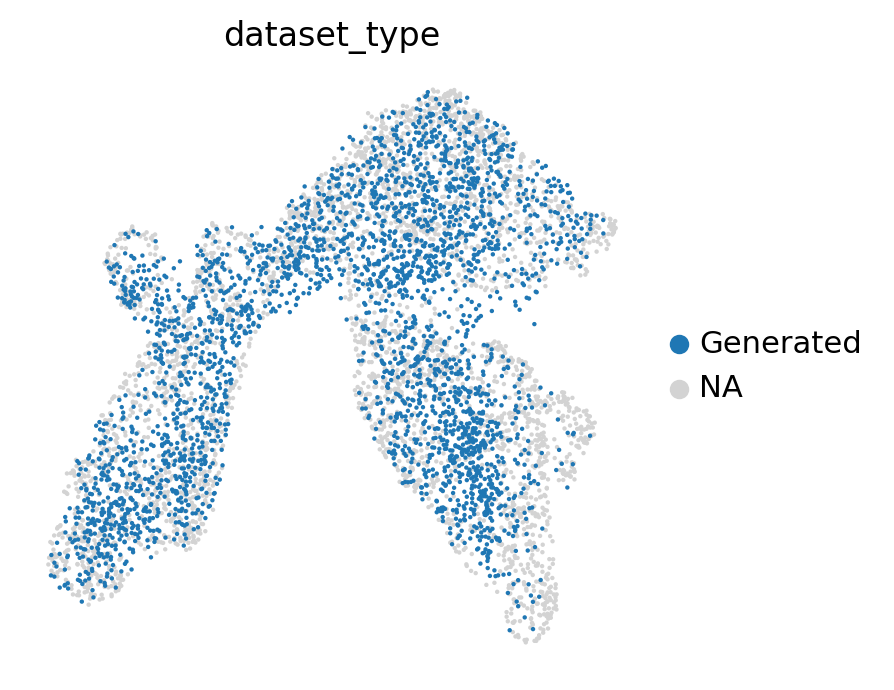

In [37]:
sc.pl.umap(adata_merged_uncond[adata_merged_uncond.obs.dataset_type=="Real"], color="Age")
sc.pl.umap(adata_merged_uncond[adata_merged_uncond.obs.dataset_type=="Real"], color="clusters")
sc.pl.umap(adata_merged_uncond, color="dataset_type", groups="Generated", s=10)